# Handwritten Digit Classfication using Deep Feed Foward Neural Network

In [1]:
%pylab inline
import pandas
import datetime as dt

from nn.layer import *
from nn.criterion import *
from optim.optimizer import *
from util.common import *
from dataset.transformer import *
from dataset import mnist

init_engine()

Populating the interactive namespace from numpy and matplotlib


In [69]:
# Get and store MNIST into RDD of Sample
mnist_path = "/home/yang/sources/datasets/mnist"
def get_minst(data_type="train"):
    # target is start from 0,
    (images, labels) = mnist.read_data_sets(mnist_path, data_type)
    mean = np.mean(images)
    std = np.std(images)
    images = sc.parallelize(images)
    labels = sc.parallelize(labels)
    
    record = images.zip(labels).map(lambda (features, label):
        Sample.from_ndarray(np.resize((features - mean)/std, (784,)), label + 1)) # Both features and labels are ndarray, and BigDL target starts from 1
    return record

train_data = get_minst("train")
test_data = get_minst("test")
print train_data.count()
print test_data.count()

('Extracting', '/home/yang/sources/datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


In [70]:
# Transform Image samples through map function
 # train_data = train_rdd.map(normalizer(mnist.TRAIN_MEAN, mnist.TRAIN_STD))
# test_data = val_rdd.map(normalizer(mnist.TEST_MEAN, mnist.TEST_STD))

In [71]:
# Parameters
learning_rate = 0.2
training_epochs = 15
batch_size = 2048
display_step = 1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [72]:
# Create model

def multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Linear(n_input, n_hidden_1))
    model.add(ReLU())
    # Hidden layer with ReLu activation
    model.add(Linear(n_hidden_1, n_hidden_2))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_2, n_classes))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_hidden_2, n_input, n_classes)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


In [73]:
# Create an Optimizer
state = {"learningRate": learning_rate}
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method="SGD",
    state=state,
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.setvalidation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=["Top1Accuracy"]
)

app_name='multilayer_perceptron-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to ",app_name

creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  multilayer_perceptron-20170418-140003


In [74]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.6 s


In [75]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1


Ground Truth labels:
7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9
CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 355 ms


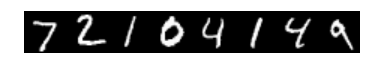

In [76]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label)) for s in test_data.take(8))
#print 'Ground Truth:'
#print '\t'.join([str(s.label) for s in ground_truth])
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))

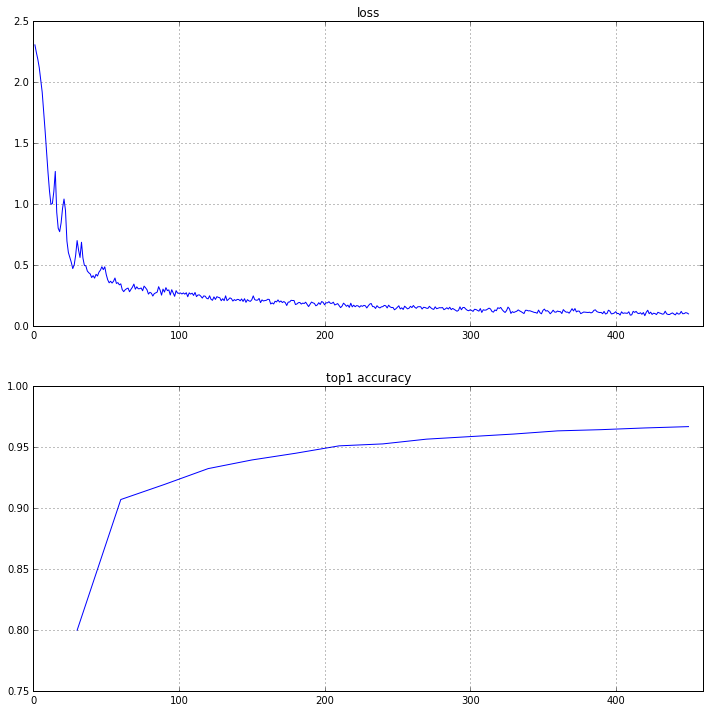

In [77]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)